In [11]:
import torch 
from torch.utils.data import Dataset, DataLoader 
from torch.utils.data.dataloader import default_collate
import torchvision
import cv2

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
pd.set_option("display.max_rows", None)
import time
import glob

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

## Test filtering corrupted images in Dataset and Dataloader

In [12]:
# dataset class to load images
def make_dataset(data_path):
    img_paths = glob.glob(data_path + "/*.jpg")
    samples = []
    for img_path in img_paths:
        img_id = int(img_path.split("/")[-1].split('.')[0])
        samples.append((img_id, img_path))
    return samples

class ImageDataset(Dataset):
    def __init__(self, data_path):
        super(Dataset, self).__init__()
        self.transform = torchvision.transforms.Compose(
            [torchvision.transforms.ToTensor()]
            )
        self.images = make_dataset(data_path)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_id, img_path = self.images[index]

        img = cv2.imread(img_path)
        # handle corrupted images
        if img is None:
            return None
        else:
            # resize to (C, H, W)
            img = cv2.resize(img, (img.shape[1], img.shape[0]))
            # resize to the same shape to load the data by batch
            img = cv2.resize(img, (1200, 1200))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = self.transform(img)
            return img_id, img

In [13]:
dataset = ImageDataset("../../../HKTVMall_data")

In [16]:
def collate_fn(batch):
    batch = filter(lambda img: img is not None, batch)
    return default_collate(list(batch))

In [21]:
data_loader = DataLoader(
        dataset, 
        batch_size=32, 
        num_workers=0, shuffle=False, drop_last=False,
        collate_fn=collate_fn
    )

In [23]:
for _id, img in data_loader:
    print(img.shape)

torch.Size([32, 3, 1200, 1200])
torch.Size([32, 3, 1200, 1200])
torch.Size([31, 3, 1200, 1200])
torch.Size([32, 3, 1200, 1200])
torch.Size([32, 3, 1200, 1200])
torch.Size([32, 3, 1200, 1200])
torch.Size([32, 3, 1200, 1200])
torch.Size([32, 3, 1200, 1200])
torch.Size([32, 3, 1200, 1200])
torch.Size([32, 3, 1200, 1200])
torch.Size([32, 3, 1200, 1200])
torch.Size([32, 3, 1200, 1200])
torch.Size([32, 3, 1200, 1200])
torch.Size([32, 3, 1200, 1200])
torch.Size([16, 3, 1200, 1200])


## Faster R-CNN for testing on a single image

In [2]:
def read_image(base_path, image_id, print_size=False):
    file_path = '%s/%s.jpg' % (base_path, image_id)
    image = cv2.imread(file_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    width = image.shape[1]
    height = image.shape[0]
    
    # resize to (H, W, C)
    image = cv2.resize(image, (width, height))
    
    if print_size:
        print("Image %d: %d x %d " % (image_id, width, height))
    
    return image, width, height

In [3]:
def plot_image(indices, boxes, classes, scores, image, image_id, pct_area_thres=0.1):
    area, pct_area, confs = [], 0, []
    image_size = image.shape[0] * image.shape[1]
    
    for i in indices:
        box = boxes[i]
        # filter person class, class_label = 1
        if classes[i] == 1:
            # filter bounding box size
            bbox_area = (box[3] - box[1]) * (box[2] - box[0])
            if bbox_area / image_size > pct_area_thres:
                area.append(bbox_area)
                confs.append(scores[i])
                
                cv2.rectangle(image, 
                          (int(box[0]), int(box[1])), 
                          (int(box[2]), int(box[3])), 
                          (255, 0, 0), 2
                )
    
    if len(area) == 0:
        pct_area, avg_conf = 0, 0
    else:
        pct_area = np.mean(area) / image_size
        avg_conf = np.mean(confs)
    
    plt.figure()
    plt.title("Image {}: {:.0%} of area is classified as person at {:.0%} confidence".format(
                    image_id, pct_area, avg_conf)
    )
    plt.imshow(image)
    plt.show()
    plt.close()
    
    return pct_area, avg_conf

In [4]:
def predict(model, image, conf_thres=0.2):
    """
    @param model: pre-trained model
    @param image: image array
    @param conf_thres: confidence threshold to filter bounding boxes
    @param pct_area_thres: threshold to filter bounding box size
    """
    # transform image to tensor
    transform = torchvision.transforms.Compose(
        [torchvision.transforms.ToTensor()]
    )
    image = transform(image)
    # one image at a time
    predictions = model([image])[0]
    
    boxes = predictions["boxes"].detach().numpy()
    classes = predictions["labels"].numpy()
    scores = predictions["scores"].detach().numpy()
    
    indices = np.where(scores > conf_thres)[0]
    
    return indices, boxes, classes, scores

- Use Faster R-CNN model with ResNet50 as backbone and pre-trained on COCOtrain2017

In [5]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, progress=False)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

- try on one image

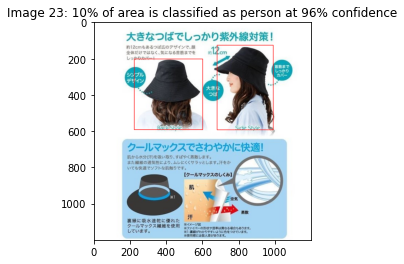

In [7]:
image_id = 23
image, _, _ = read_image("../../../HKTVMall_data", image_id, print_size=False)
indices, boxes, classes, scores = predict(model, image, conf_thres=0.7)
pct_area, avg_conf = plot_image(indices, boxes, classes, scores, image, image_id, pct_area_thres=0.15)

- get image_ids

In [19]:
image_ids = [int(x.split("/")[-1].split(".")[0]) for x in glob.glob("images/*.jpg")]
image_ids.sort()
len(image_ids)

100

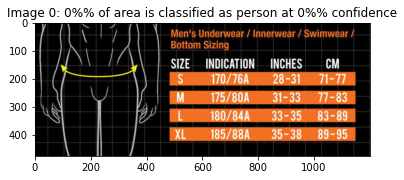

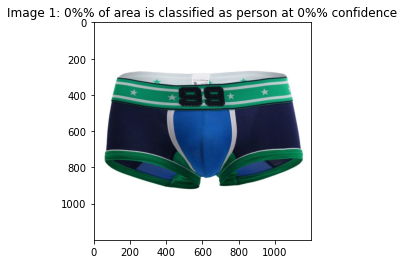

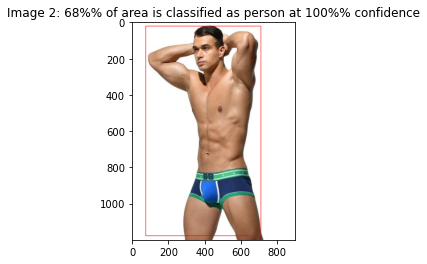

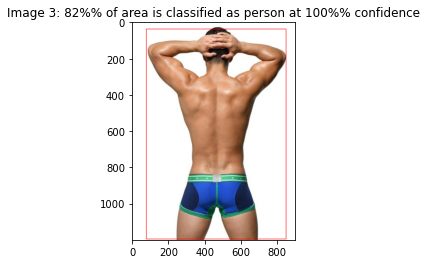

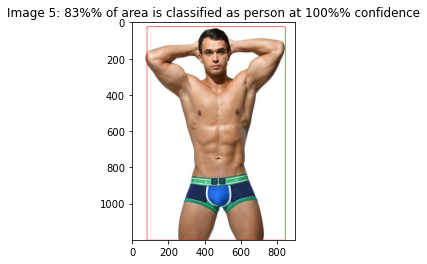

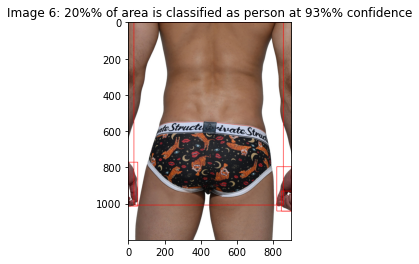

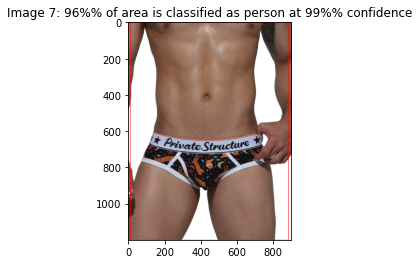

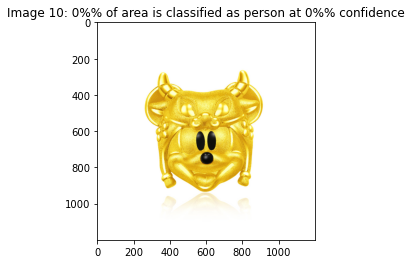

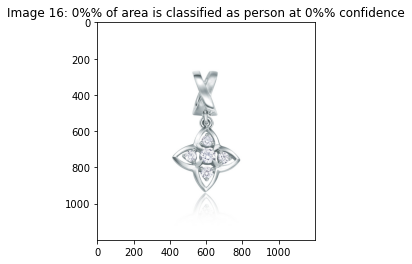

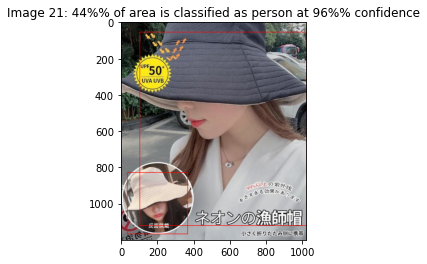

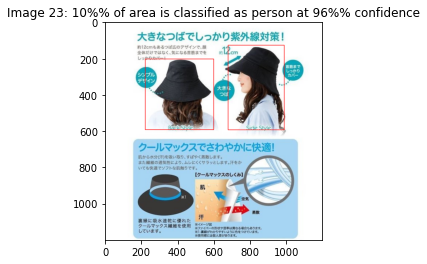

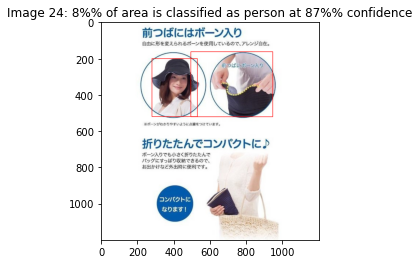

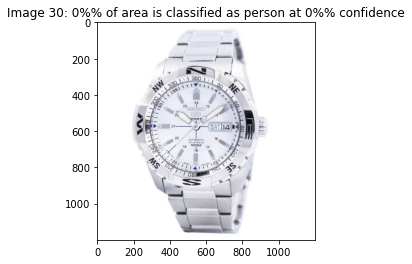

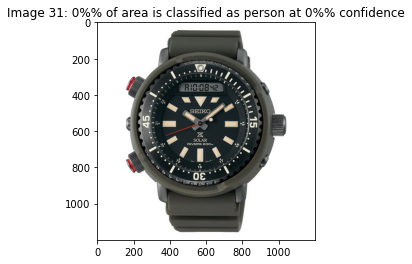

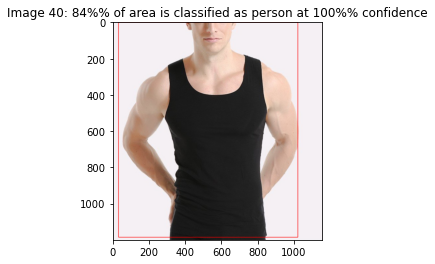

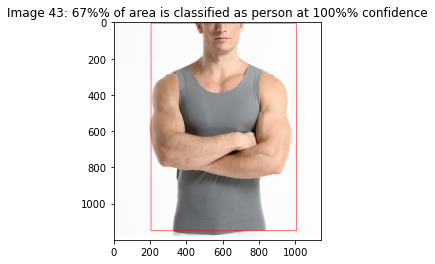

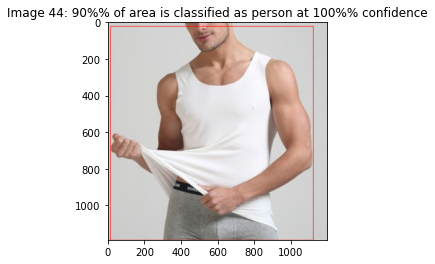

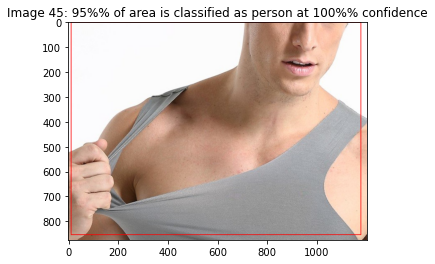

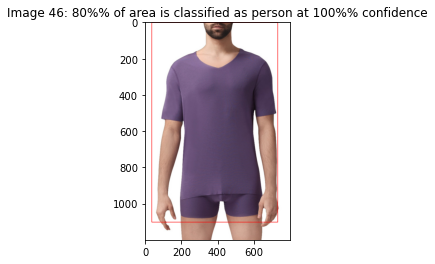

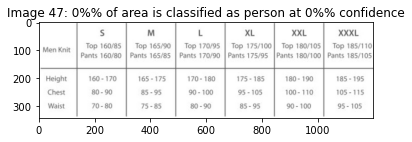

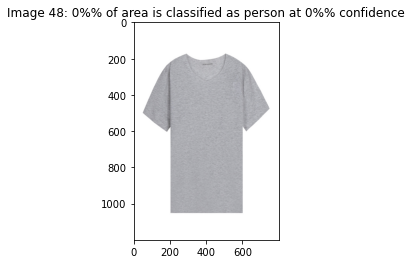

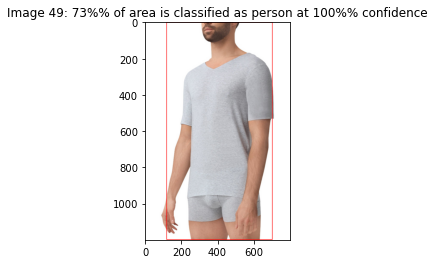

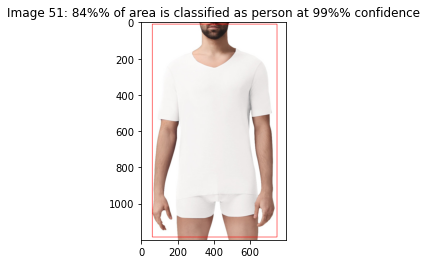

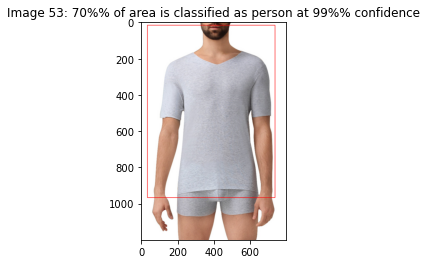

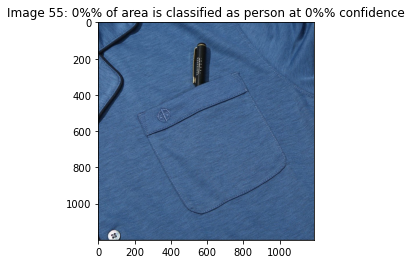

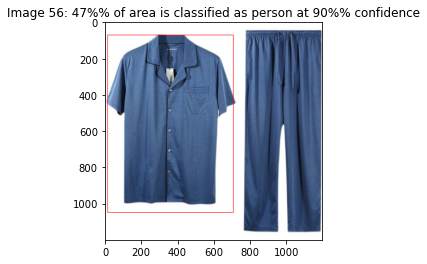

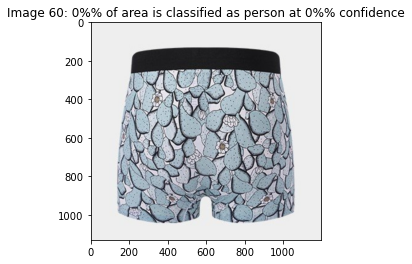

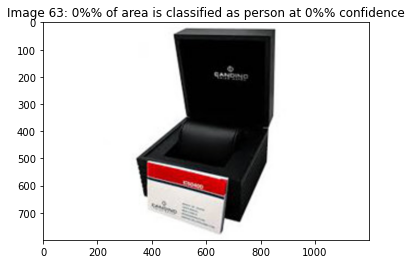

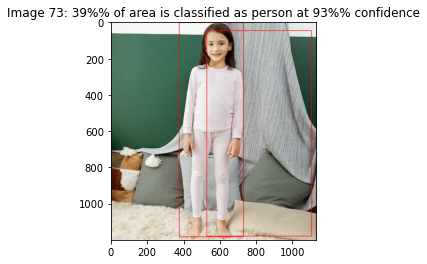

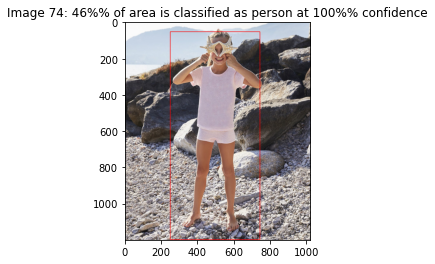

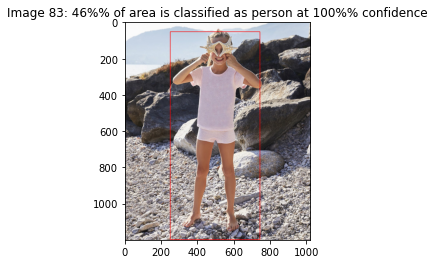

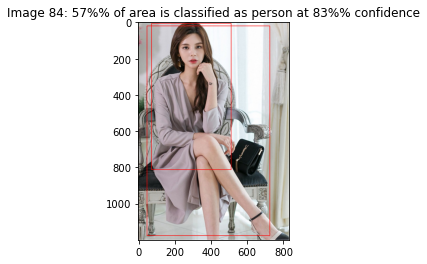

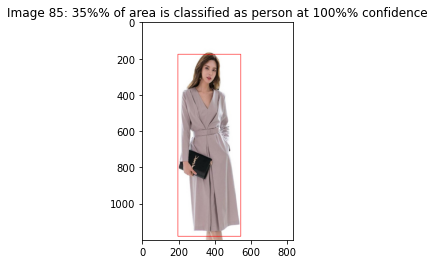

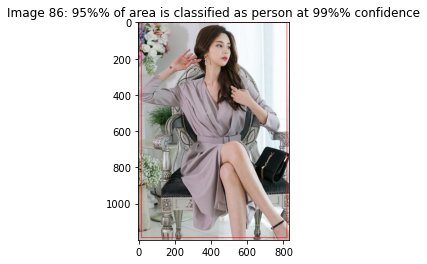

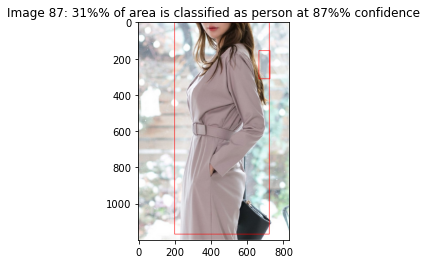

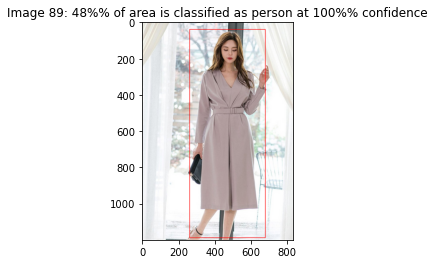

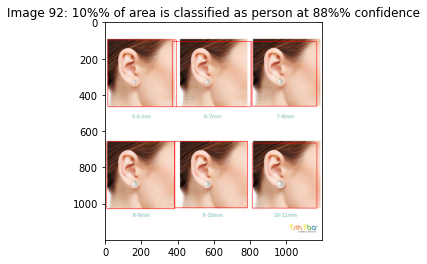

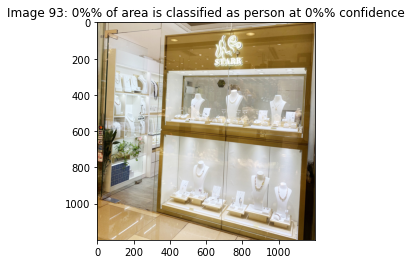

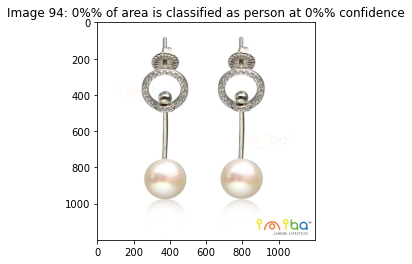

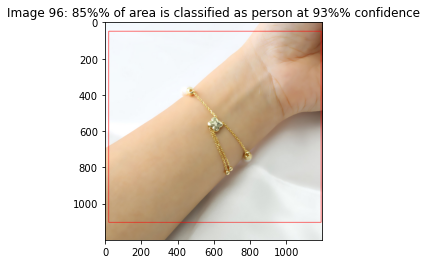

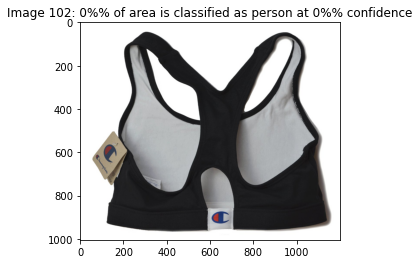

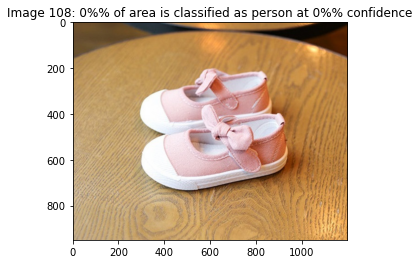

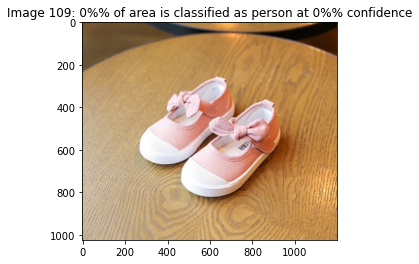

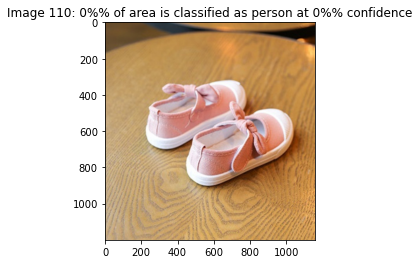

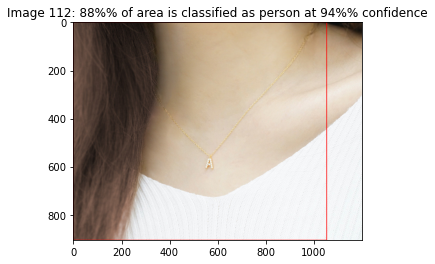

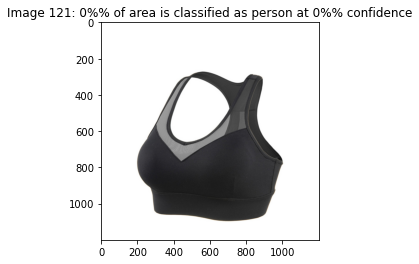

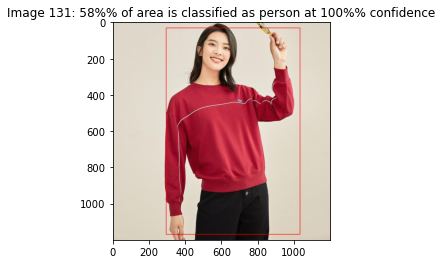

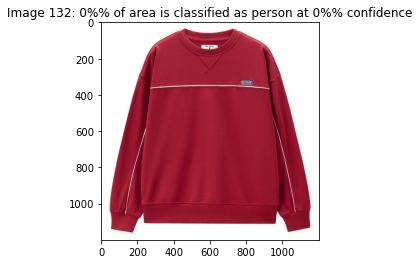

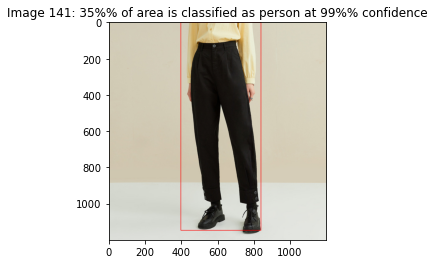

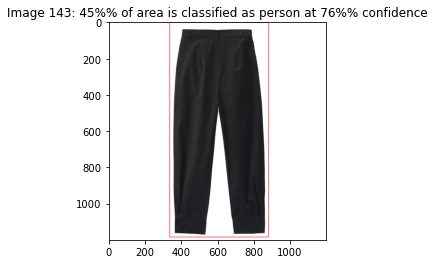

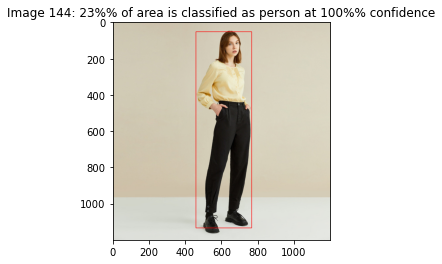

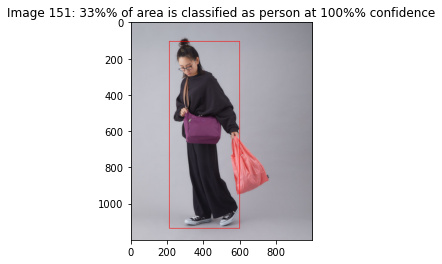

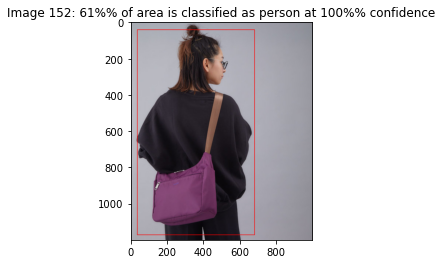

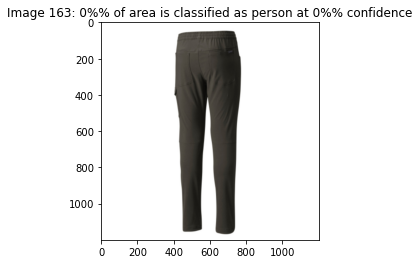

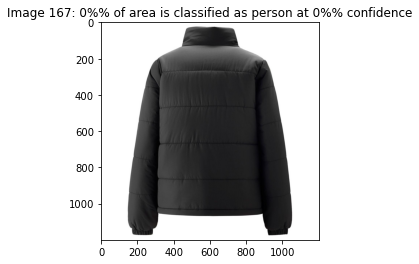

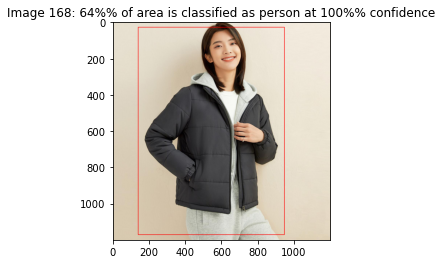

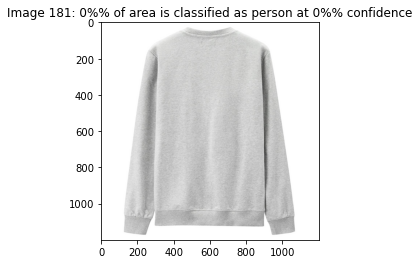

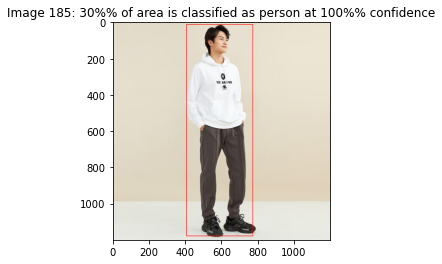

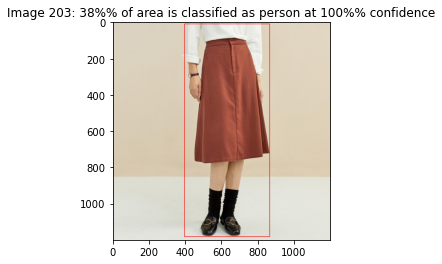

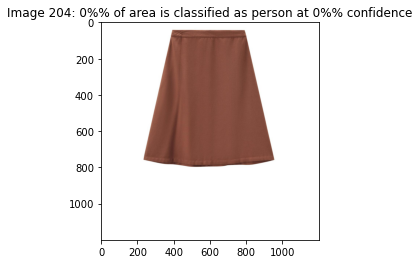

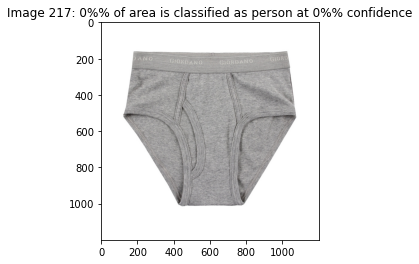

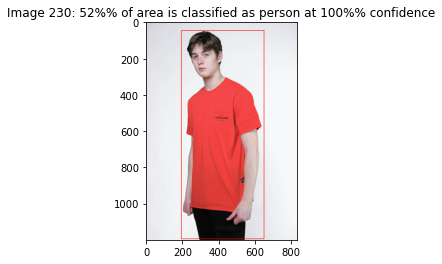

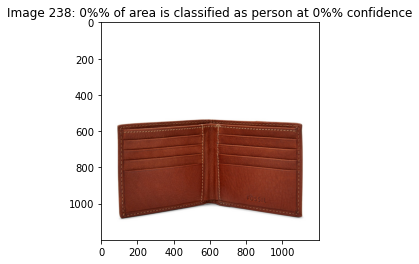

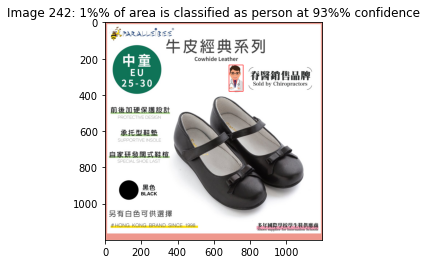

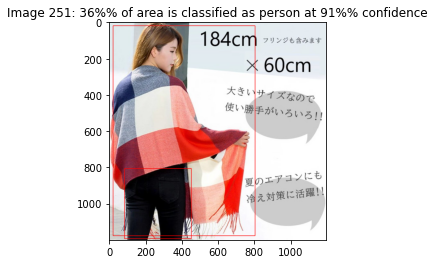

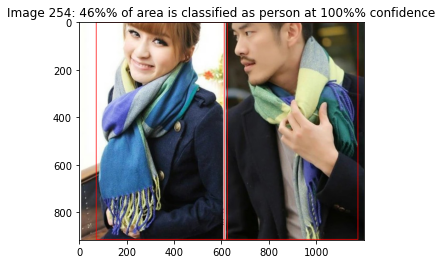

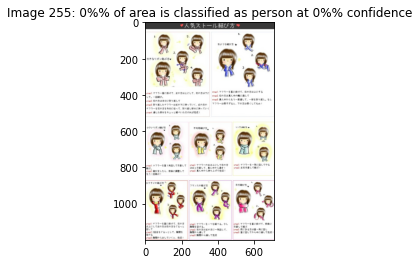

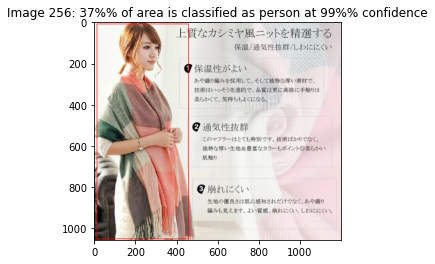

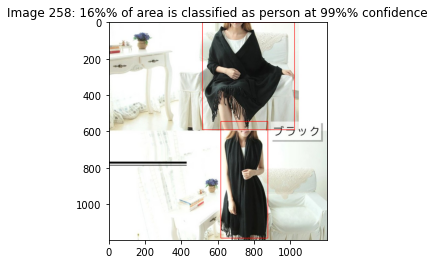

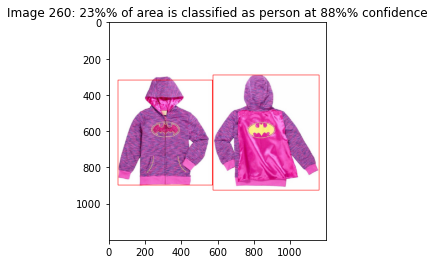

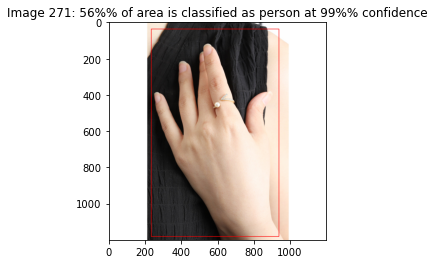

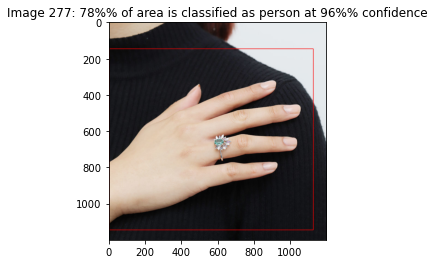

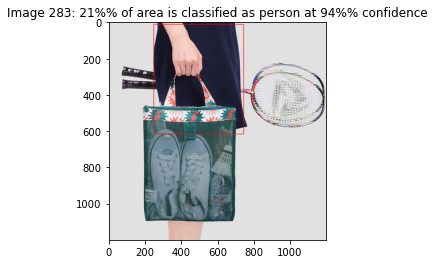

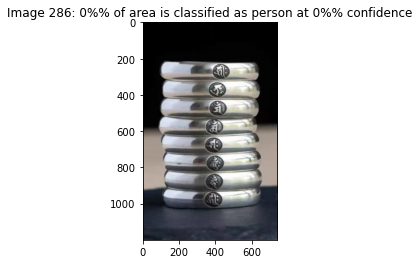

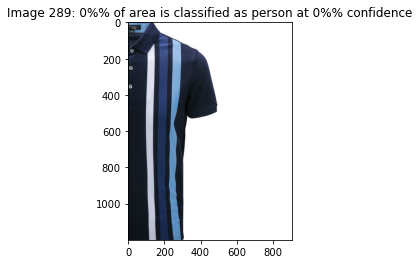

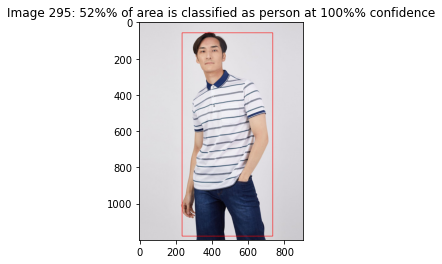

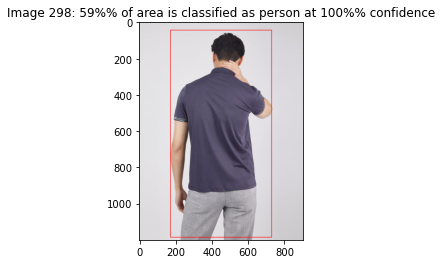

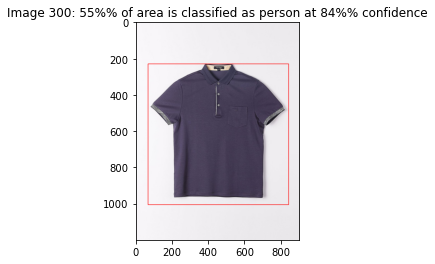

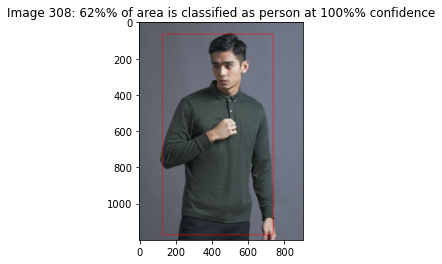

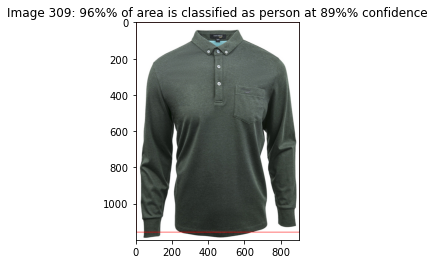

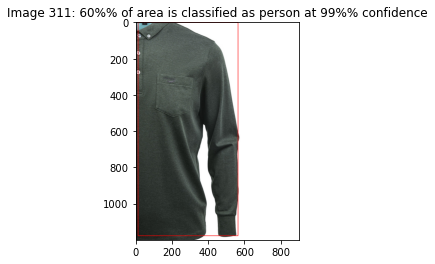

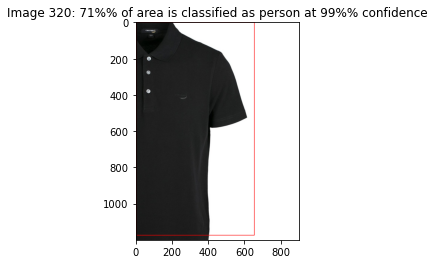

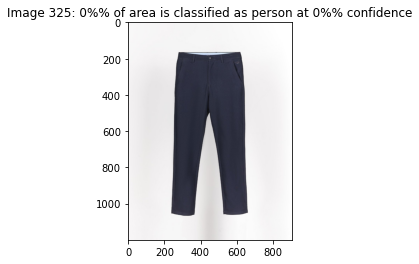

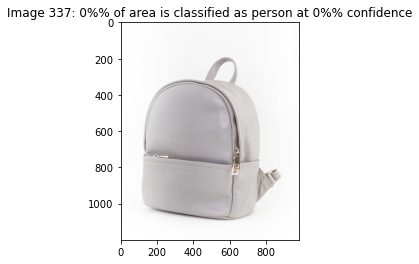

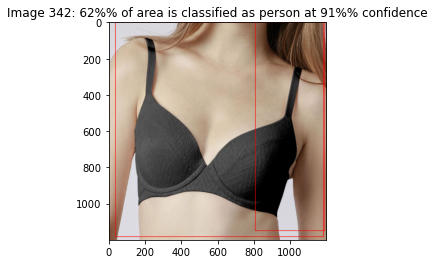

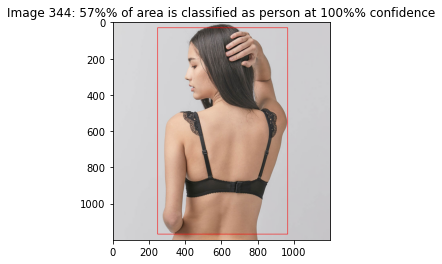

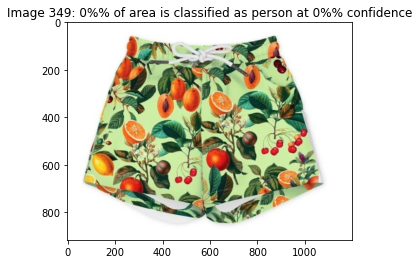

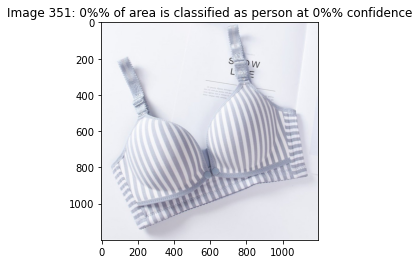

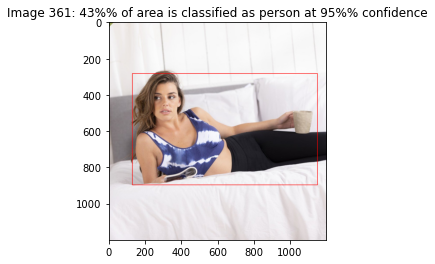

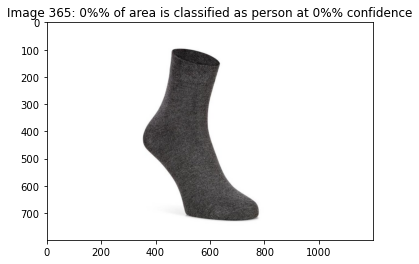

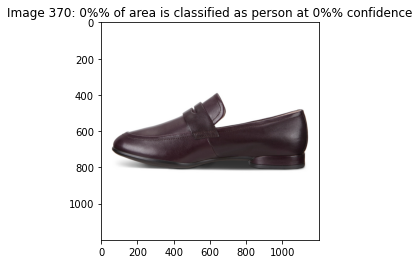

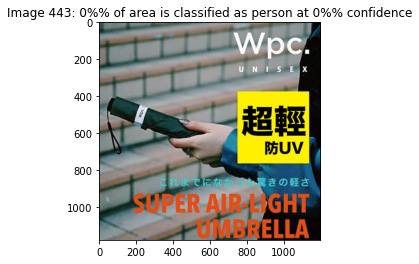

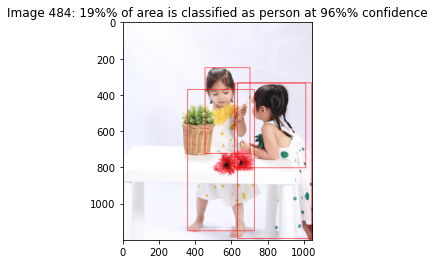

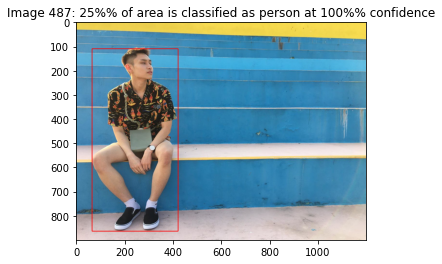

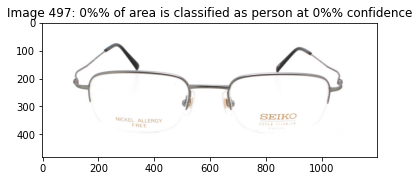

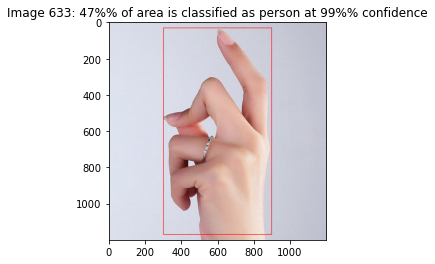

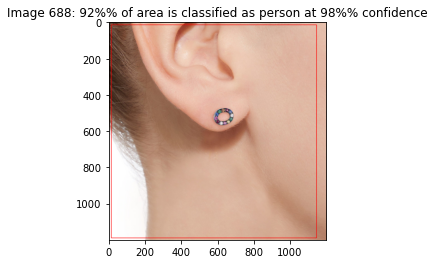

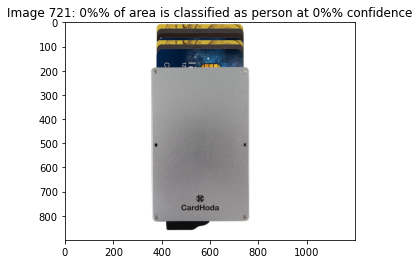

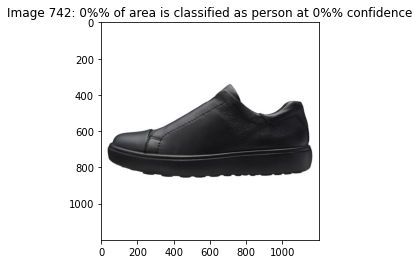

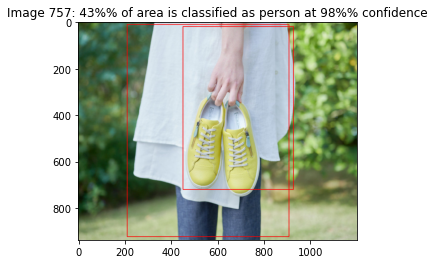

Total time used : 479.81


In [20]:
start = time.time()

result_dict = {"image_id": [], "pct_area": [], "avg_conf": [], "frcnn_pred": []}
conf_thres = 0.7

for image_id in image_ids:
    image, _, _ = read_image("images", image_id, print_size=False)
    indices, boxes, classes, scores = predict(model, image, conf_thres=conf_thres)
    pct_area, avg_conf = plot_image(indices, boxes, classes, scores, image, image_id)

    if pct_area > 0.05:
        result_dict["faster_rcnn_pred"].append(1)
    else:
        result_dict["faster_rcnn_pred"].append(0)
    
    result_dict["image_id"].append(image_id)
    result_dict["pct_area"].append(pct_area)
    result_dict["avg_conf"].append(avg_conf)


    result_df = pd.DataFrame.from_dict(result_dict, orient="columns")
result_df = result_df.sort_values("image_id")
result_df.to_csv("result/frcnn_pred.csv", index=False)

end = time.time()
print("Total time used : %.2f" % (end-start))

## Performance on 100 images
- Total time used:
    - Faster R-CNN: 479s
    - YOLOv3: 73s
    - Human parsing: 3 min

In [5]:
def evaluate(model_name, time_used, df, pred_col, label_col="y_true"):
    acc = accuracy_score(df["y_true"], df[pred_col])
    precision = precision_score(df["y_true"], df[pred_col])
    recall = recall_score(df["y_true"], df[pred_col])
    f1 = f1_score(df["y_true"], df[pred_col])
    
    print(model_name)
    print("total time used: %d seconds" % time_used)
    print("accuracy: {:.2%}".format(acc), 
          "precision: {:.2%}".format(precision), 
          "recall: {:.2%}".format(recall),
          "f1: {:.2%}".format(f1))
    print("confusion matrix")
    print(confusion_matrix(df["y_true"], df[pred_col]), "\n")

In [6]:
yolo_res = pd.read_csv("result/yolo_320_result.csv")
par_res = pd.read_csv("result/human_parsing_result.csv")
real_time_res = pd.read_csv("result/real_time_pred.csv")
frcnn_res = pd.read_csv("result/frcnn_pred.csv")

label = pd.read_csv("result/true_label.csv")

In [7]:
res = frcnn_res.merge(label, on="image_id")
evaluate("Faster R-CNN", 479, res, "frcnn_pred", label_col="y_true")

res = yolo_res.merge(label, on="image_id")
evaluate("YOLOv3", 73, res, "yolo_pred", label_col="y_true")

res = real_time_res.merge(label, on="image_id")
evaluate("Real-time human detection", 53, res, "pred_label", label_col="y_true")

res = par_res.merge(label, on="image_id")
evaluate("Human Parsing", 180, res, "par_pred", label_col="y_true")

Faster R-CNN
total time used: 479 seconds
accuracy: 92.00% precision: 88.52% recall: 98.18% f1: 93.10%
confusion matrix
[[38  7]
 [ 1 54]] 

YOLOv3
total time used: 73 seconds
accuracy: 89.00% precision: 86.67% recall: 94.55% f1: 90.43%
confusion matrix
[[37  8]
 [ 3 52]] 

Real-time human detection
total time used: 53 seconds
accuracy: 85.00% precision: 84.48% recall: 89.09% f1: 86.73%
confusion matrix
[[36  9]
 [ 6 49]] 

Human Parsing
total time used: 180 seconds
accuracy: 85.00% precision: 97.62% recall: 74.55% f1: 84.54%
confusion matrix
[[44  1]
 [14 41]] 

